In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, TimeDistributed, RepeatVector
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 불러오기
df = pd.read_csv('../../Data/using/dt_2.6/ByAstar_dt_2.6_1016.csv')

df = df.dropna(subset=['combination'])


2023-11-17 15:14:47.012092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 15:14:47.802956: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
from math import *

def hermitian_matrix_to_vector(matrix):
    # 행렬의 크기를 가져옴
    n = matrix.shape[0]

    # 에르미트 행렬인지 확인
    assert np.allclose(matrix, matrix.conj().T)

    # 상삼각 행렬의 원소를 가져와 벡터로 변환
    vector = np.zeros((n * (n + 1)) // 2, dtype=complex)
    idx = 0
    for i in range(n):
        for j in range(i + 1):
            vector[idx] = matrix[i, j]
            idx += 1

    return vector

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])
    
# Initial state
init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave, init_wave.conj().T)

def making_rho(theta, phi):

    # Target state
    # Theta must move first and then phi move.
    target_U = Rz(theta) @ Rx(phi) 
    irho_target = target_U @ irho_init @ target_U.conj().T
    
    return irho_target

df['Rho'] = df.apply(lambda row: hermitian_matrix_to_vector(making_rho(row['Theta'], row['Phi'])), axis=1)

In [5]:
df['Rho'][0]

array([1.54338977e-01+0.j        , 3.55493008e-05-0.36127338j,
       8.45661023e-01+0.j        ])

In [48]:
import tensorflow as tf

# 데이터셋 분리: train_set 8 : test_set 2
train_df, test_df = train_test_split(df, shuffle=True, test_size=0.2)
# train_set을 다시 8:2로 나눠서 train_set과 validation_set을 만듦
train_df, val_df = train_test_split(train_df, shuffle=True, test_size=0.2)
# random_state=42

# 모든 시퀀스의 길이 중에서 최대 길이를 구하기
all_sequences = [eval(str(seq)) for seq in df['combination'].values]
max_seq_length = max([len(seq) for seq in all_sequences])

# 각 데이터셋에서 theta, phi, sequence 추출하고 reshape 적용
theta_train = train_df['Theta'].values.reshape(-1, 1)
phi_train = train_df['Phi'].values.reshape(-1, 1)
# rho_train = train_df['Rho'].values.reshape(-1, 1)
rho_train_list = train_df['Rho'].apply(lambda x: np.asarray(x).flatten()).tolist()
rho_train = tf.constant(np.stack(rho_train_list))
sequence_train = pad_sequences(train_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_val = val_df['Theta'].values.reshape(-1, 1)
phi_val = val_df['Phi'].values.reshape(-1, 1)
# rho_val = val_df['Rho'].values.reshape(-1, 1)
rho_val_list = val_df['Rho'].apply(lambda x: np.asarray(x).flatten()).tolist()
rho_val = tf.constant(np.stack(rho_val_list))
sequence_val = pad_sequences(val_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_test = test_df['Theta'].values.reshape(-1, 1)
phi_test = test_df['Phi'].values.reshape(-1, 1)
# rho_test = test_df['Rho'].values.reshape(-1, 1)
rho_test_list = test_df['Rho'].apply(lambda x: np.asarray(x).flatten()).tolist()
rho_test = tf.constant(np.stack(rho_test_list))
sequence_test = pad_sequences(test_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')


In [49]:
print("rho_train shape:", rho_train.shape)
print("rho_train dtype:", rho_train.dtype)
print("rho_val shape:", rho_val.shape)
print("rho_val dtype:", rho_val.dtype)


rho_train shape: (18897, 3)
rho_train dtype: <dtype: 'complex128'>
rho_val shape: (4725, 3)
rho_val dtype: <dtype: 'complex128'>


In [50]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 모델 정의

ds_rho_input = Input(shape=(3,), name='density_matrix_input')

# 시퀀스를 예측하기 위한 GRU 레이어
repeated_vector = RepeatVector(max_seq_length)(ds_rho_input)  # max_sequence_length는 시퀀스의 최대 길이

rnn_layer = GRU(512, return_sequences=True, name='rnn_layer')(repeated_vector)

output = TimeDistributed(Dense(5, activation='softmax'), name='output_layer')(rnn_layer)

model = Model(inputs=[ds_rho_input], outputs=output)

# 컴파일 및 훈련
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

history = model.fit([rho_train], np.expand_dims(sequence_train, -1), 
                    validation_data=([rho_val], np.expand_dims(sequence_val, -1)), epochs=500, batch_size=64,
                    callbacks=[early_stopping])

# 검증
loss, accuracy = model.evaluate([rho_test], np.expand_dims(sequence_test, -1))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/500


2023-11-17 13:31:26.852504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-17 13:31:26.853749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-17 13:31:26.854659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-11-17 13:31:27.379239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-17 13:31:27.380658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-17 13:31:27.381763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

294/296 [============================>.] - ETA: 0s - loss: 1.2916 - accuracy: 0.4838WARNING:tensorflow:You are casting an input of type complex128 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.


2023-11-17 13:31:37.737588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-17 13:31:37.738591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-17 13:31:37.739785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

296/296 [==============================] - 11s 34ms/step - loss: 1.2914 - accuracy: 0.4838 - val_loss: 1.2497 - val_accuracy: 0.5012
Epoch 2/500
296/296 [==============================] - 10s 33ms/step - loss: 1.2545 - accuracy: 0.4884 - val_loss: 1.1864 - val_accuracy: 0.4896
Epoch 3/500
296/296 [==============================] - 10s 33ms/step - loss: 0.9140 - accuracy: 0.6181 - val_loss: 0.8243 - val_accuracy: 0.6429
Epoch 4/500
296/296 [==============================] - 10s 33ms/step - loss: 0.7884 - accuracy: 0.6538 - val_loss: 0.7430 - val_accuracy: 0.6687
Epoch 5/500
296/296 [==============================] - 10s 33ms/step - loss: 0.7439 - accuracy: 0.6628 - val_loss: 0.7375 - val_accuracy: 0.6641
Epoch 6/500
296/296 [==============================] - 10s 33ms/step - loss: 0.7244 - accuracy: 0.6673 - val_loss: 0.7189 - val_accuracy: 0.6578
Epoch 7/500
296/296 [==============================] - 10s 33ms/step - loss: 0.7038 - accuracy: 0.6716 - val_loss: 0.6957 - val_accuracy: 0.66

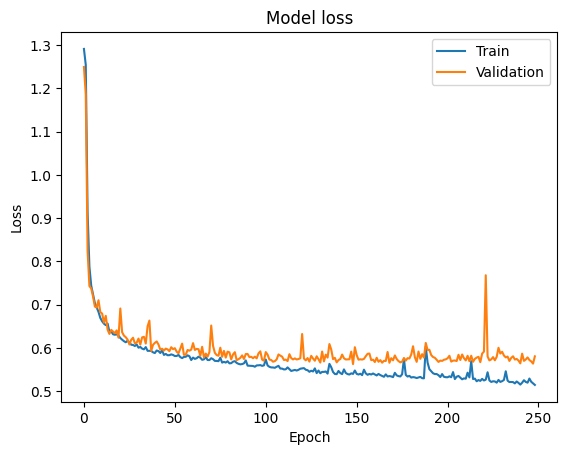

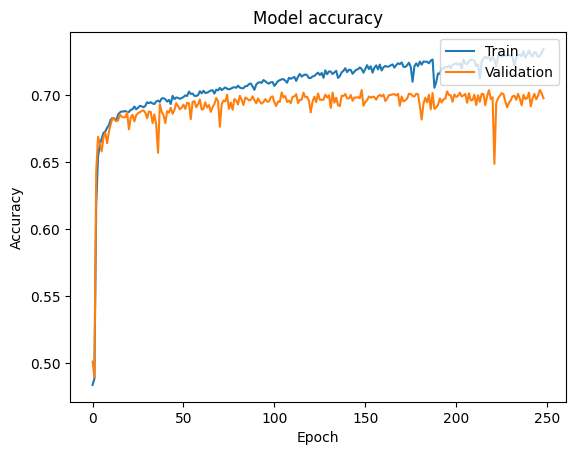

 18/185 [=>............................] - ETA: 0s - loss: 0.5667 - accuracy: 0.7091 

2023-11-17 14:06:31.379039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-17 14:06:31.380520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-17 14:06:31.381200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

185/185 [==============================] - 1s 3ms/step - loss: 0.5621 - accuracy: 0.6985
Test Accuracy: 69.85
Test Loss: 56.21


In [51]:
def plot_history(history):
         # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        # plt.axis([45, 70, 0, 0.01])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        # plt.axis([45, 60, 0.999, 1.0])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

def evaluate(model, rho, sequence):
    loss, acc = model.evaluate({'density_matrix_input': rho}, np.expand_dims(sequence, -1))
    print("Test Accuracy: {:.2f}".format(acc*100))
    print("Test Loss: {:.2f}".format(loss*100))

# 결과 그래프 그리기
plot_history(history)

# 모델 성능 평가
evaluate(model, rho_test, sequence_test)

In [52]:
# 결과를 저장할 디렉토리 생성
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
# 모델 저장
model.save(os.path.join(models_dir, "NVspin_GRU_model_Rho.h5"))

# # 모델 불러오기
# from tensorflow.keras.models import load_model
# loaded_model = load_model("SimpleRNN_model.h5")

In [53]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(rho_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
rho_samples = np.array(rho_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([rho_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과를 DataFrame으로 변환
df_results = pd.DataFrame({
    'Theta': theta_samples.ravel(),
    'Phi': phi_samples.ravel(),
    'Actual Sequence': [list(seq) for seq in sequence_samples],
    'Predicted Sequence': [list(seq) for seq in predicted_sequences]
})

# 결과를 저장할 디렉토리 생성
results_dir = 'sample_GRU'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# 결과를 CSV 파일로 저장
df_results.to_csv(os.path.join(results_dir, 'GRU_cuda_results_Rho.csv'), index=False)

print("Results saved to GRU_cuda_results_Rho.csv")


1/1 [==============================] - 0s 171ms/step
Results saved to GRU_cuda_results_Rho.csv


2023-11-17 14:06:32.218921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-17 14:06:32.220158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-17 14:06:32.221199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [54]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(rho_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
rho_samples = np.array(rho_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([rho_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과 출력
for i in range(10):
    print(f"Sample {i + 1}:")
    print("Theta    :", theta_samples[i])
    print("Phi      :", phi_samples[i])
    print("Actual   :", sequence_samples[i])
    print("Predicted:", predicted_sequences[i])
    print("----------")


1/1 [==============================] - 0s 14ms/step
Sample 1:
Theta    : [0.46108278]
Phi      : [0.03036552]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 4 4 1]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 1 0 3 0 2 0 4 1 1 3 3 2 2 0 4 1]
----------
Sample 2:
Theta    : [0.43896558]
Phi      : [2.39216249]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 3 3]
Predicted: [0 0 0 0 2 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 3 3]
----------
Sample 3:
Theta    : [2.87599871]
Phi      : [3.82249342]
Actual   : [0 0 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 1 0 3]
Predicted: [0 0 0 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 1 0 2]
----------
Sample 4:
Theta    : [0.82266448]
Phi      : [0.95489396]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 3 3 2 2 4 4 4 3]
Predicted: [0 0 0 0 0 0 0 0 0 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 4 0]
----------
Sample 5